## 第五章 常用工具
* 数据处理
* 可视化
* GPU 加速

### 5.1 数据处理
#### 5.1.1 数据加载
**小例子**

In [3]:
%env LS_COLORS = None
!tree --charset ascii data/dogcat/

env: LS_COLORS=None
/bin/sh: tree: command not found


In [5]:
import torch as t
from torch.utils import data

In [131]:
import numpy as np
from PIL import Image
import os

class DogCat1(data.Dataset):
    def __init__(self, root):
        img_names = os.listdir(root)
        self.imgs = [os.path.join(root,img) for img in img_names] # absolute name for each file in root directory
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label
    
    def __len__(self):
        return len(self.imgs)
    

In [132]:
dataset = DogCat1('./data/dogcat/')
img, label = dataset[0]
for img, label in dataset:
    print(img.shape, img.float().mean(), label)

torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([499, 379, 3]) tensor(171.8085) 0
torch.Size([375, 499, 3]) tensor(116.8139) 1
torch.Size([374, 499, 3]) tensor(115.5177) 0
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1


**问题**
* 样本大小不一
* 样本像素值没有归一化

**怎么办？**  
* 用 torchvision.transforms 来解决！

**torchvision 的例子**

In [122]:
from torchvision import transforms as T
import os
import numpy as np
from PIL import Image

transform = T.Compose([
    T.Resize(224),  # 缩放到224
    T.CenterCrop(224), # 从中心切出224大小的块儿
    T.ToTensor(), # 自动归一化
    T.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) # 标准化
])

class DogCat(data.Dataset): # 重新写 DogCat，命名不带数字和之前作区分
    def __init__(self, root, transforms = None): # 引入 transforms
        img_names = os.listdir(root)
        self.imgs = [os.path.join(root,img) for img in img_names] # absolute name for each file in root directory
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        
        if self.transforms:
            data = self.transforms(data) # transform 会把 image 转换成 tensor
        return data, label
    
    def __len__(self):
        return len(self.imgs)
    
dataset = DogCat('data/dogcat', transforms = transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.shape, label)


torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1


**用 ImageFolder 去读取数据**  
ImageFolder 假设所有的文件按文件夹保存，每个文件夹下存储同一个标注的图片。

In [123]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('data/dogcat_2')

In [124]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [45]:
dataset.imgs

[('data/dogcat_2/cat/cat.12484.jpg', 0),
 ('data/dogcat_2/cat/cat.12485.jpg', 0),
 ('data/dogcat_2/cat/cat.12486.jpg', 0),
 ('data/dogcat_2/cat/cat.12487.jpg', 0),
 ('data/dogcat_2/dog/dog.12496.jpg', 1),
 ('data/dogcat_2/dog/dog.12497.jpg', 1),
 ('data/dogcat_2/dog/dog.12498.jpg', 1),
 ('data/dogcat_2/dog/dog.12499.jpg', 1)]

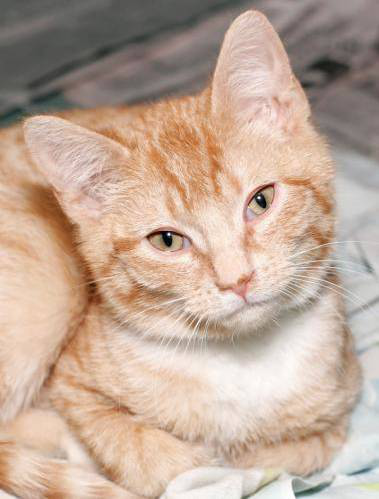

In [52]:
# dataset 里是最原始的 PIL 图片。
dataset[1][0]

In [56]:
# 手动加 transform
normalize = T.Normalize(mean=[.4,.4,.4],std=[.2,.2,.2])
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

torch.Size([3, 224, 224])
tensor(1.3536)
下面就是转换后的效果


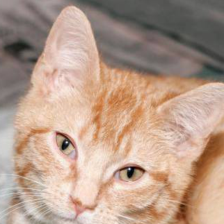

In [83]:
# 重新导入数据集，这次用上 transform
dataset = ImageFolder('data/dogcat_2',transform = transform)

# 查看数据集现在的尺寸
print(dataset[1][0].shape)
print(dataset[1][0].mean())

# 已经标准化。

# 把 tensor 转换回 image
to_img = T.ToPILImage()
print('下面就是转换后的效果')
to_img(dataset[1][0] * .2 + .4)


在上面的代码里我们得到了单个的数据，每个数据都是一张图片。但实际上，神经网络处理的对象是很多数据组成的一批数据，俗称一个 batch。pytorch 也为我们提供了处理 batch 数据的强力工具——DataLoader。
#### DataLoader 的定义
```python
DataLoader(dataset, batch_size = 1, shuffle = False, sampler = None, num_workers = 0, collate_fn = default_collate, pin_memory = False, drop_last = False)
```
* dataset：加载的数据集
* batch_size：这个就是 batch_size 咯
* shuffle：是否将数据打乱
* sampler：样本抽样方法，可以自行定义，稍后会用权重抽样来定义一个
* num_workers：雇用几个工人来干活（使用几个进程）
* collate_fn：如何将样本拼接成一个 batch，选择默认即可
* pin_memory：是否将数据保存在 pin memory 区
* drop_last：dataset 数据个数可能不是 batch_size 的整数倍，如果多出来不足一个 batch 的数据，是否丢弃

In [136]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size = 3, shuffle = True)

In [82]:
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.shape

torch.Size([3, 3, 224, 224])

#### Dataloader 
* DataLoader 是一个可迭代对象
    ```python
    for batch_data, batch_label in dataloader:
        train()
    ```
    等价于
    ```python
    dataiter = iter(dataloader)
    data, labels = next(dataiter)
    ```
* 如果某个样本出错，可以先返回 None，然后在 dataloader 里面实现自定义的 collate_fn，剔除 None 对象。当然最后得到的 batch 个数会小于 batch_size
* 

In [125]:
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            print('wrong')
            return None, None

from torch.utils.data.dataloader import default_collate

def my_collate_fn(batch):
    batch = list(filter(lambda x:x[0] is not None, batch)) # 在 batch 里逐个检查样本图像维是否是 None
    if len(batch) == 0: 
        return t.Tensor()
        print('all samples are empty...WTF')
    return default_collate(batch)
    

In [128]:
dataset = NewDogCat('./data/dogcat_wrong', transforms = transform)
dataset[0]

(tensor([[[-0.1137, -0.0667, -0.0667,  ...,  0.4902,  0.4118,  0.4039],
          [-0.2235, -0.1843, -0.1608,  ...,  0.4824,  0.4039,  0.3961],
          [-0.3020, -0.2471, -0.2078,  ...,  0.4980,  0.4039,  0.3961],
          ...,
          [-0.7255, -0.7176, -0.7333,  ..., -0.5608, -0.5451, -0.4039],
          [-0.7647, -0.7176, -0.7098,  ..., -0.5608, -0.5451, -0.4039],
          [-0.7804, -0.7569, -0.7176,  ..., -0.5608, -0.5451, -0.4039]],
 
         [[ 0.1451,  0.1765,  0.1686,  ...,  0.4510,  0.3490,  0.3255],
          [ 0.0275,  0.0510,  0.0745,  ...,  0.4431,  0.3490,  0.3098],
          [-0.0667, -0.0196,  0.0118,  ...,  0.4510,  0.3490,  0.3176],
          ...,
          [-0.6235, -0.6392, -0.6471,  ..., -0.4196, -0.4353, -0.3098],
          [-0.6627, -0.6392, -0.6235,  ..., -0.4196, -0.4353, -0.3098],
          [-0.6784, -0.6784, -0.6314,  ..., -0.4196, -0.4353, -0.3098]],
 
         [[ 0.6784,  0.7490,  0.7490,  ...,  0.0275, -0.0667, -0.0745],
          [ 0.5294,  0.5843,

In [130]:
dataloader = DataLoader(dataset, 2, collate_fn = my_collate_fn, num_workers = 1, shuffle = True)
for img, label in dataloader:
    print(img.shape,label.shape)

# 成功 debug

wrong
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([1, 3, 224, 224]) torch.Size([1])


一共9张图片，某一个 batch 里有一张坏图被扔掉了，所以 batch 容量变成2-1=1，4个 batch 一共8个，剩下一个样本不够分，在最后单独成为一个 batch。如果设置 drop_last = True，可以扔掉这个多出来的数据。  
这样对数据进行了全面清洗。虽然结果的 batch_size 减少了，但能够彻底去掉不合格的数据，以后也推荐使用。

#### Sampler  

使用 WeightRandomSampler 可以在样本不均衡时实现权重采样

In [133]:
dataset = DogCat('data/dogcat/', transforms = transform)

# 取出狗图片的概率是猫的概率的两倍
weights = [2 if label == 1 else 1 for data, label in dataset]
weights

[2, 1, 1, 2, 1, 1, 2, 2]

In [140]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights,       # 每个样本被抽中的概率
                              num_samples = 9,  # 要抽样的样本数是9个
                              replacement = True) # 允许重复抽取某一个样本
dataloader = DataLoader(dataset,
                        batch_size = 3,
                        sampler = sampler)

for data, label in dataloader:
    print(label.tolist())

[0, 0, 0]
[1, 1, 0]
[0, 1, 0]


可见，猫狗样本比例约为 1:2。另外允许了 replacement，所以从8个样本里抽取出了9个样本。  
实际上，如果制定了 sampler，那么 shuffle 参数就被覆盖了从而失效，而且实际返回的样本数量取决于 sampler.num_samples 这个参数。

### 5.2 计算机视觉工具包：torchvision 系统性介绍
torchvision 主要包含三部分：
* models
* datasets
* transforms


### 5.3 可视化工具
最简单的办法就是打印。但还是不够直观，想看更多，那就需要可视化工具。  
#### 5.3.1 TensorBoard
通过 tensorboard_logger 在 pytorch 中使用 tensorboard


#### 5.3.2 Visdom  
Facebook 专门为 pytorch 开发的可视化工具。  

Visdom 的两个重要概念：  
* env：环境。不同环境的可视化结果相互隔离，互不影响。默认为 main。
* pane：窗格。用于可视化图像、数值，打印文本等。可以拖动，缩放，保存和关闭。一个程序可以使用一个 env 中的不同 pane，每个 pane 可视化或记录某一种信息。

两个使用要点：
* 需要手动保存 env，重启后消失。
* 客户端与服务器端采用 tornado 非阻塞交互，断网也不会导致程序退出。

### 5.4 使用 GPU 加速：cuda
本机（MacBook Pro）没有 GPU，本节略。  

#### 一些注意事项：  
并行计算指一机装有多个显卡。指定在哪块 GPU 上运行：
  * Jupyter Notebook: `%env CUDA_VISIBLE_DEVICES = 1,2` # 设置使用第二块和第三块 GPU
  * 程序中: `import os; os.environ['CUDA_VISIBLE_DEVICES'] = 2`

### 5.5 持久化
以下对象可以持久化到硬盘：
* Tensor
* Variable
* nn.Module
* Optimizer

本质都是保存成 tensor。
* 对于 module，主要保存 **state_dict** 而不是整个 module。
* 对于 optimizer，主要保存 parameter 和 **momentum**。